# Programming Assignment-1 [February 24,2024]
- Shuvrajeet Das
- Nataraj

In [1]:
from math import floor
import numpy as np


def row_col_to_seq(row_col, num_cols):  # Converts state number to row_column format
    return row_col[:, 0] * num_cols + row_col[:, 1]


def seq_to_col_row(seq, num_cols):  # Converts row_column format to state number
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])


class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """

    def __init__(self, num_rows, num_cols, start_state, goal_states, wind=False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1  # default is no discounting
        self.wind = wind

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward=None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward

    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows  # +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        # self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(
                self.bad_states[i, :].reshape(1, -1), self.num_cols)
            # print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception(
                    "Restart state specified but no reward is given")
            restart_state = row_col_to_seq(
                self.restart_states[i, :].reshape(1, -1), self.num_cols)
            # print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception(
                "Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states, self.num_states, self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):

                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1, 2, 1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col), 1) == 0):
                        next_state = row_col_to_seq(
                            self.start_state, self.num_cols)
                        self.P[state, :, :] = 0
                        self.P[state, next_state, :] = 1
        return self

    def _get_direction(self, action, direction):

        left = [2, 3, 1, 0]
        right = [3, 2, 0, 1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1, 1, 0, 0]
        col_change = [0, 0, -1, 1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0, 0] += row_change[direction]
        row_col[0, 1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:, 0] > self.num_rows-1) or
                np.any(row_col[:, 1] > self.num_cols-1) or
                    np.any(np.sum(abs(self.obs_states - row_col), 1) == 0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:, 0] > self.num_rows-1) or
                    np.any(row_col[:, 1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state

    def reset(self):
        return int(self.start_state_seq)

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break

        if (self.wind and np.random.random() < 0.4):

            arr = self.P[next_state, :, 3]
            next_next = np.where(arr == np.amax(arr))
            next_next = next_next[0][0]
            return next_next, self.R[next_next]
        else:
            return next_state, self.R[next_state]

In [2]:
def create_environment(start_state, wind, p_good_transition):
    num_cols = 10
    num_rows = 10
    obstructions = np.array([[0, 7], [1, 1], [1, 2], [1, 3], [1, 7], [2, 1], [2, 3],
                            [2, 7], [3, 1], [3, 3], [3, 5], [
                                4, 3], [4, 5], [4, 7],
                            [5, 3], [5, 7], [5, 9], [6, 3], [
                                6, 9], [7, 1], [7, 6],
                            [7, 7], [7, 8], [7, 9], [8, 1], [8, 5], [8, 6], [9, 1]])
    bad_states = np.array([[1, 9], [4, 2], [4, 4], [7, 5], [9, 9]])
    restart_states = np.array([[3, 7], [8, 2]])
    goal_states = np.array([[0, 9], [2, 2], [8, 7]])

    gw = GridWorld(num_rows=num_rows,
                   num_cols=num_cols,
                   start_state=start_state,
                   goal_states=goal_states, wind=wind)
    gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
    gw.add_rewards(step_reward=-1,
                   goal_reward=10,
                   bad_state_reward=-6,
                   restart_state_reward=-100)
    gw.add_transition_probability(p_good_transition=p_good_transition,
                                  bias=0.5)
    env = gw.create_gridworld()
    return env

In [3]:
import tqdm

def epsilon_greedy(Q, state, epsilon):
    number_of_actions = Q.shape[1]
    if np.random.rand() < epsilon:
        action = np.random.randint(number_of_actions)
    else:
        action = np.argmax(Q[state, :])
    return action


def softmax(Q, state, beta):
    q = Q[state, :] / beta
    probability = np.exp(q - np.max(q))
    probability /= np.sum(probability)
    number_of_actions = Q.shape[1]
    return np.random.choice(number_of_actions, p=probability)

# Q Learning

In [17]:
class QLearning:
    def __init__(self, env, strategy, param, lr, gamma, horizon=100):
        self.env = env
        self.stategy = strategy
        self.param = param
        self.lr = lr
        self.gamma = gamma
        self.horizon = horizon

    def check_terminal_state(self, state):
        goal_states = self.env.goal_states_seq
        return state in goal_states

    def train(self, number_of_episodes):
        env = self.env
        strategy = self.stategy
        reward_per_episode, steps_per_episode = np.zeros(
            number_of_episodes), np.zeros(number_of_episodes)
        Q = np.zeros((env.num_states, env.num_actions))
        state_visit_count = np.zeros(env.num_states)

        for episode in range(number_of_episodes):
            total_reward, steps = 0, 0
            state = env.reset()
            action = strategy(
                Q, state, self.param)
            state_visit_count[state] += 1

            while (not self.check_terminal_state(state)) and (steps < self.horizon):
                next_state, reward = env.step(state, action)
                next_action = strategy(
                    Q, next_state, self.param)
                Q[state, action] += self.lr * \
                    (reward + self.gamma*Q[next_state,
                     next_action] - Q[state, action])
                state, action = next_state, next_action

                steps += 1
                total_reward += reward
                state_visit_count[state] += 1

            reward_per_episode[episode] = total_reward
            steps_per_episode[episode] = steps

        state_visit_count /= number_of_episodes
        return reward_per_episode, steps_per_episode, Q, state_visit_count

    def average_performance(self, number_of_epochs, number_of_episodes):
        Q_average = np.zeros((self.env.num_states, self.env.num_actions))
        state_visit_count_average = np.zeros(self.env.num_states)
        average_reward, average_steps = np.zeros(
            (number_of_epochs, number_of_episodes)), np.zeros((number_of_epochs, number_of_episodes))
        for epoch in (range(number_of_epochs)):
            reward, steps, Q, state_visit_count = self.train(
                number_of_episodes)
            average_reward[epoch] += (reward - average_reward[epoch-1]) / (epoch + 1)
            average_steps[epoch] += (steps - average_steps[epoch-1]) / (epoch + 1)
            Q_average += (Q - Q_average) / (epoch + 1)
            state_visit_count_average += (state_visit_count -
                                          state_visit_count_average) / (epoch + 1)
        return average_reward, average_steps, Q_average, state_visit_count_average

# Function plotting methods

In [18]:
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3


def mark(text):
    return display(Markdown(text))


def average_reward_plot(average_reward, episodes, title):
    fig = plt.figure()
    plt.plot(episodes, average_reward.mean(axis=0), color='red')
    plt.fill_between(episodes, average_reward.mean(axis=0)-average_reward.std(axis=0),
                     average_reward.mean(axis=0)+average_reward.std(axis=0), color='orange')
    plt.xlabel('Number of episodes')
    plt.ylabel('Average Reward')
    plt.title(title)
    plt.savefig(f'{title}-avg-rwd.png')
    plt.show()


def average_steps_plot(average_steps, episodes, title):
    fig = plt.figure()
    plt.plot(episodes, average_steps.mean(axis=0), color='blue')
    plt.fill_between(episodes, average_steps.mean(axis=0)-average_steps.std(axis=0),
                     average_steps.mean(axis=0)+average_steps.std(axis=0), color='cyan')
    plt.xlabel('Number of episodes')
    plt.ylabel('Number of steps')
    plt.title(title)
    plt.savefig(f'{title}-avg-step.png')
    plt.show()


def x_direct(a):
    if a in [UP, DOWN]:
        return 0
    return 1 if a == RIGHT else -1


def y_direct(a):
    if a in [RIGHT, LEFT]:
        return 0
    return 1 if a == UP else -1


def plot_Q(Q, title, message="Q plot"):
    D = np.zeros((10, 10))

    for i in range(10):
        D[i, 10-i-1] = 1

    Q = Q.reshape(10, 10, 4)

    for i in range(4):
        Q[:, :, i] = np.dot(D, Q[:, :, i])

    plt.figure(figsize=(8, 8))
    plt.title(f"{title}-{message}")
    plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    plt.colorbar()

    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)

    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5,
               policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    plt.xticks([])
    plt.yticks([])
    # plt.savefig(f'{title}-Q.png')
    plt.show()


def plot_step(avg_state_visit_cnt, title):
    D = np.zeros((10, 10))

    for i in range(10):
        D[i, 10-i-1] = 1

    S = np.dot(D, avg_state_visit_cnt.reshape(10, 10))
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.pcolor(S, cmap="viridis", edgecolors='k', linewidths=2)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    # plt.savefig(f'{title}-step.png')
    plt.show()


def plot_combined(average_reward, average_steps, Q, avg_state_visit_cnt, episodes, title, show=True):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Plot average reward
    axs[0, 0].plot(episodes, average_reward.mean(axis=0), color='red')
    axs[0, 0].fill_between(episodes, average_reward.mean(axis=0) - average_reward.std(axis=0),
                           average_reward.mean(axis=0) + average_reward.std(axis=0), color='orange')
    axs[0, 0].set_xlabel('Number of episodes')
    axs[0, 0].set_ylabel('Average Reward')
    axs[0, 0].set_title('Average Reward')

    # Plot average steps
    axs[0, 1].plot(episodes, average_steps.mean(axis=0), color='blue')
    axs[0, 1].fill_between(episodes, average_steps.mean(axis=0) - average_steps.std(axis=0),
                           average_steps.mean(axis=0) + average_steps.std(axis=0), color='cyan')
    axs[0, 1].set_xlabel('Number of episodes')
    axs[0, 1].set_ylabel('Number of steps')
    axs[0, 1].set_title('Average Steps')

    # Plot Q
    D = np.zeros((10, 10))
    for i in range(10):
        D[i, 10 - i - 1] = 1
    Q = Q.reshape(10, 10, 4)
    for i in range(4):
        Q[:, :, i] = np.dot(D, Q[:, :, i])

    axs[1, 0].pcolor(Q.max(-1), edgecolors='k', linewidths=2)
    axs[1, 0].set_title('Q Plot')
    plt.colorbar(axs[1, 0].pcolor(Q.max(-1)), ax=axs[1, 0])

    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)

    axs[1, 0].quiver(idx[1].ravel() + 0.5, idx[0].ravel() + 0.5,
                     policyx.ravel(), policyy.ravel(), pivot="middle", color='red')
    axs[1, 0].set_xticks([])
    axs[1, 0].set_yticks([])

    # Plot step
    D = np.zeros((10, 10))
    for i in range(10):
        D[i, 10 - i - 1] = 1
    S = np.dot(D, avg_state_visit_cnt.reshape(10, 10))

    axs[1, 1].pcolor(S, cmap="viridis", edgecolors='k', linewidths=2)
    axs[1, 1].set_title('Step Plot')
    plt.colorbar(axs[1, 1].pcolor(S), ax=axs[1, 1])
    axs[1, 1].set_xticks([])
    axs[1, 1].set_yticks([])

    fig.suptitle(title)
    plt.tight_layout()
    if show == False:
        return plt
    plt.show()

# Check performance for one particular setting of hyperparateters

In [19]:
number_of_epochs = 5
number_of_episodes = 5000
episodes = np.arange(number_of_episodes)

# Algorithm : Q-Learning, Start State : (0, 4), Exploration Strategy : EpsilonGreedy, wind = False, p = 1.0

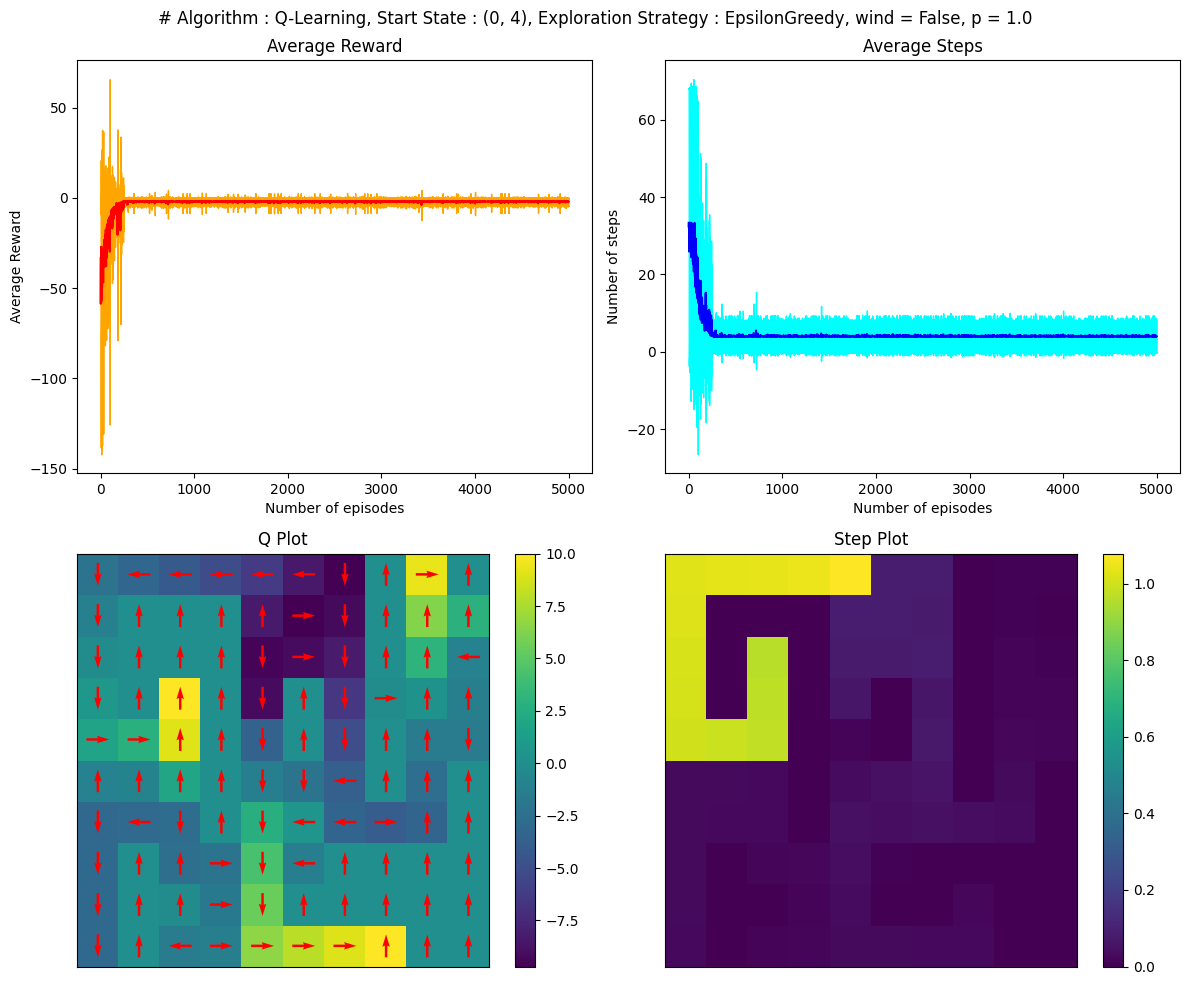

# Algorithm : Q-Learning, Start State : (0, 4), Exploration Strategy : EpsilonGreedy, wind = False, p = 0.7

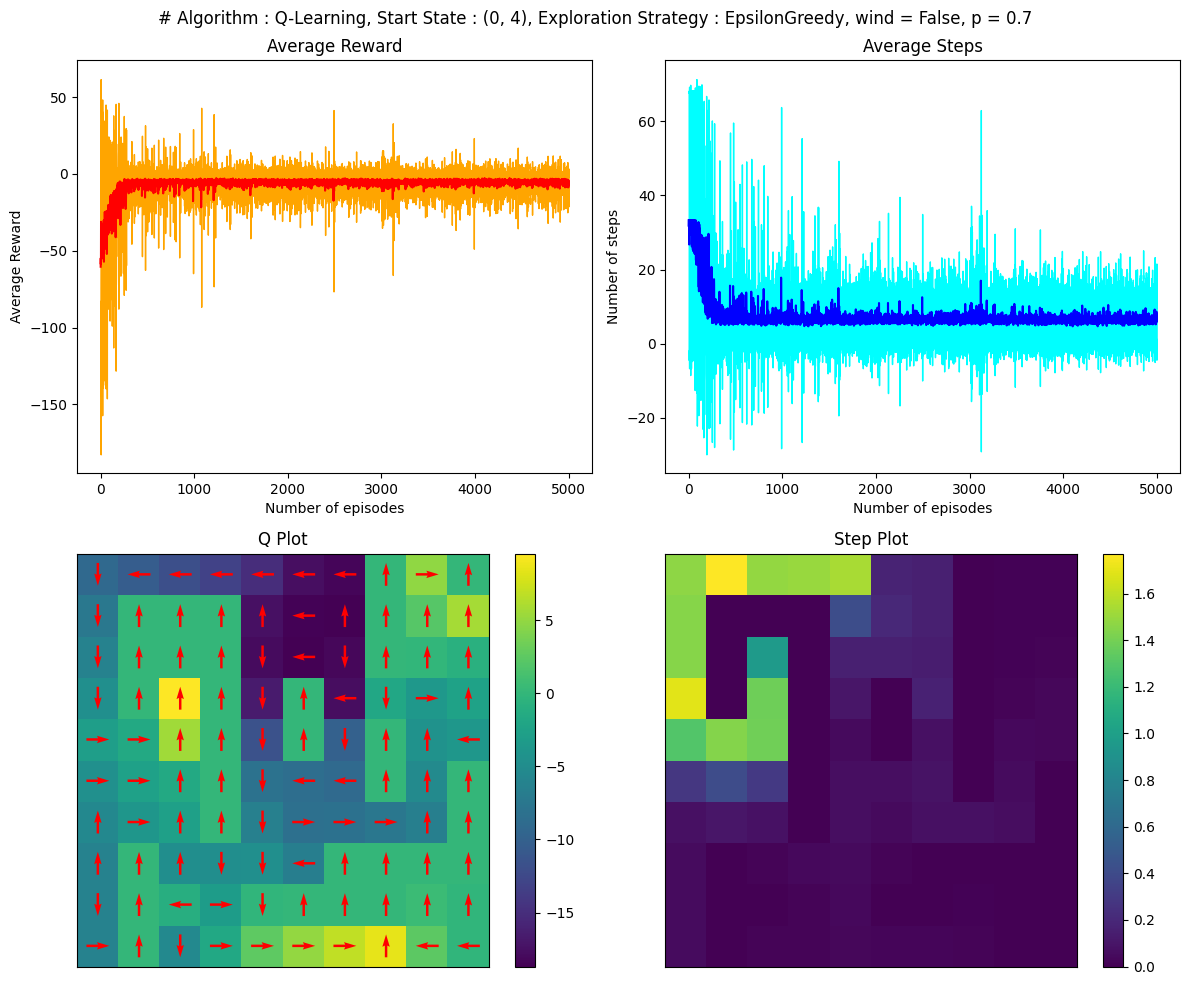

# Algorithm : Q-Learning, Start State : (0, 4), Exploration Strategy : EpsilonGreedy, wind = True, p = 1.0

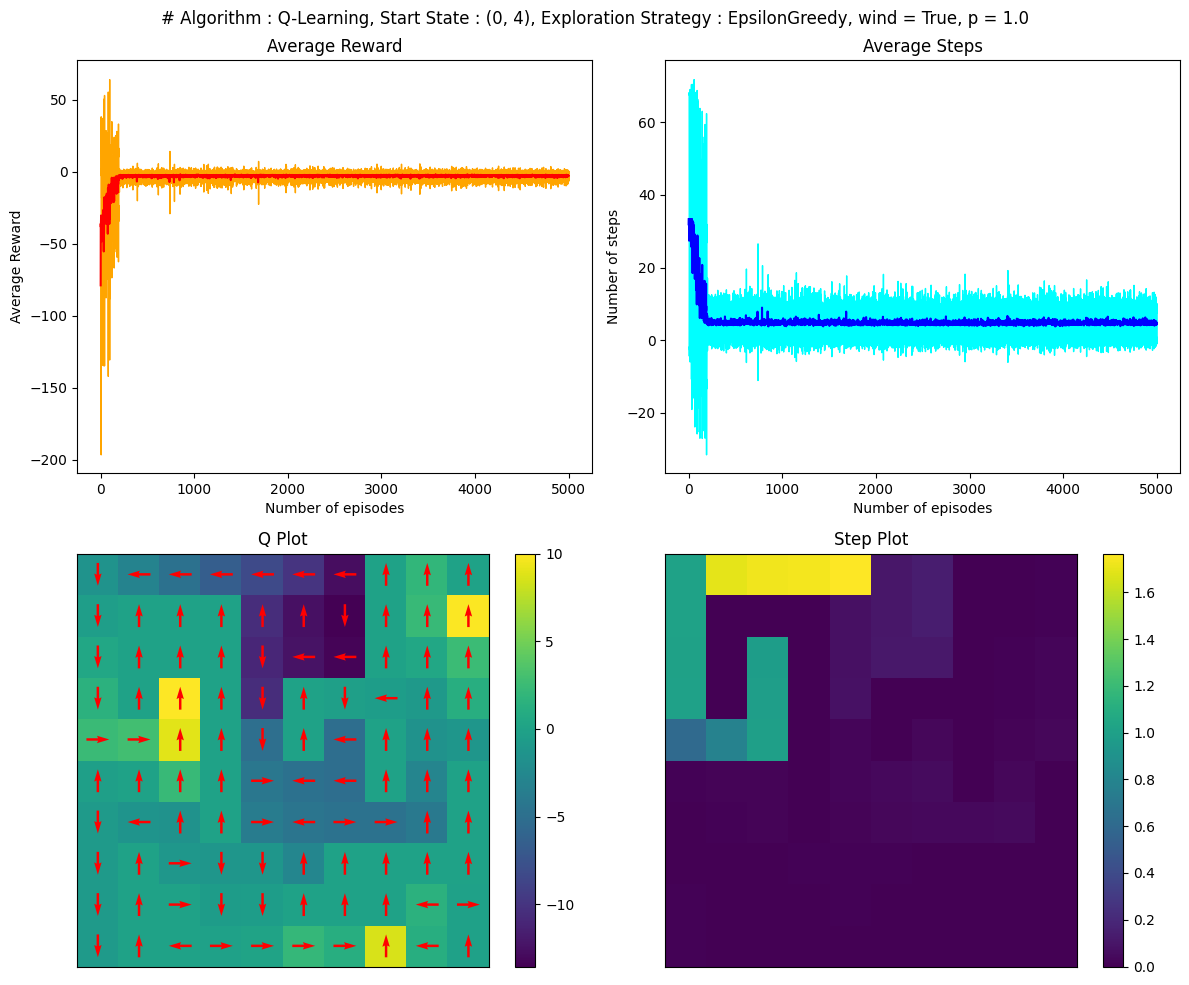

# Algorithm : Q-Learning, Start State : (3, 6), Exploration Strategy : EpsilonGreedy, wind = False, p = 1.0

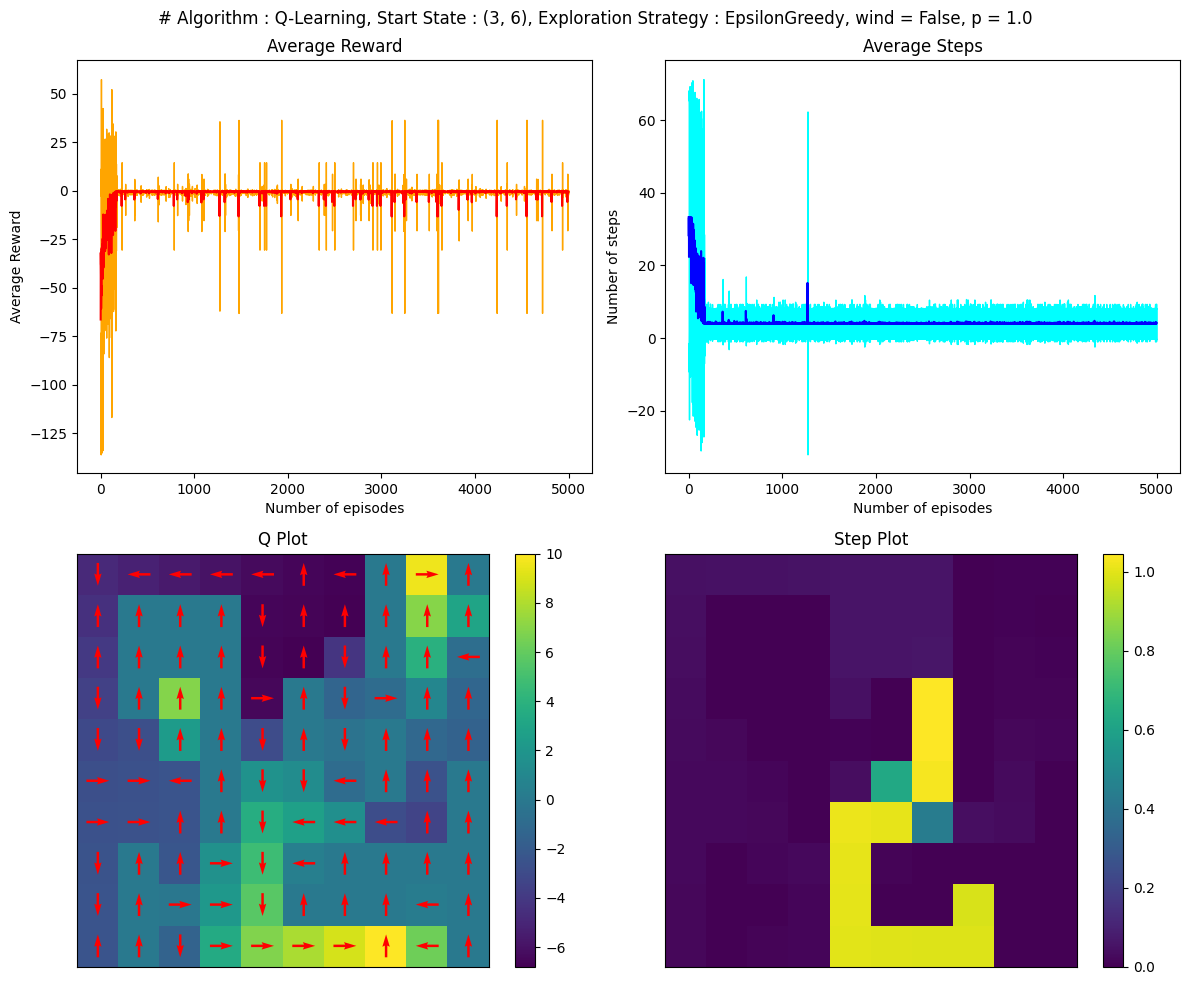

# Algorithm : Q-Learning, Start State : (3, 6), Exploration Strategy : EpsilonGreedy, wind = False, p = 0.7

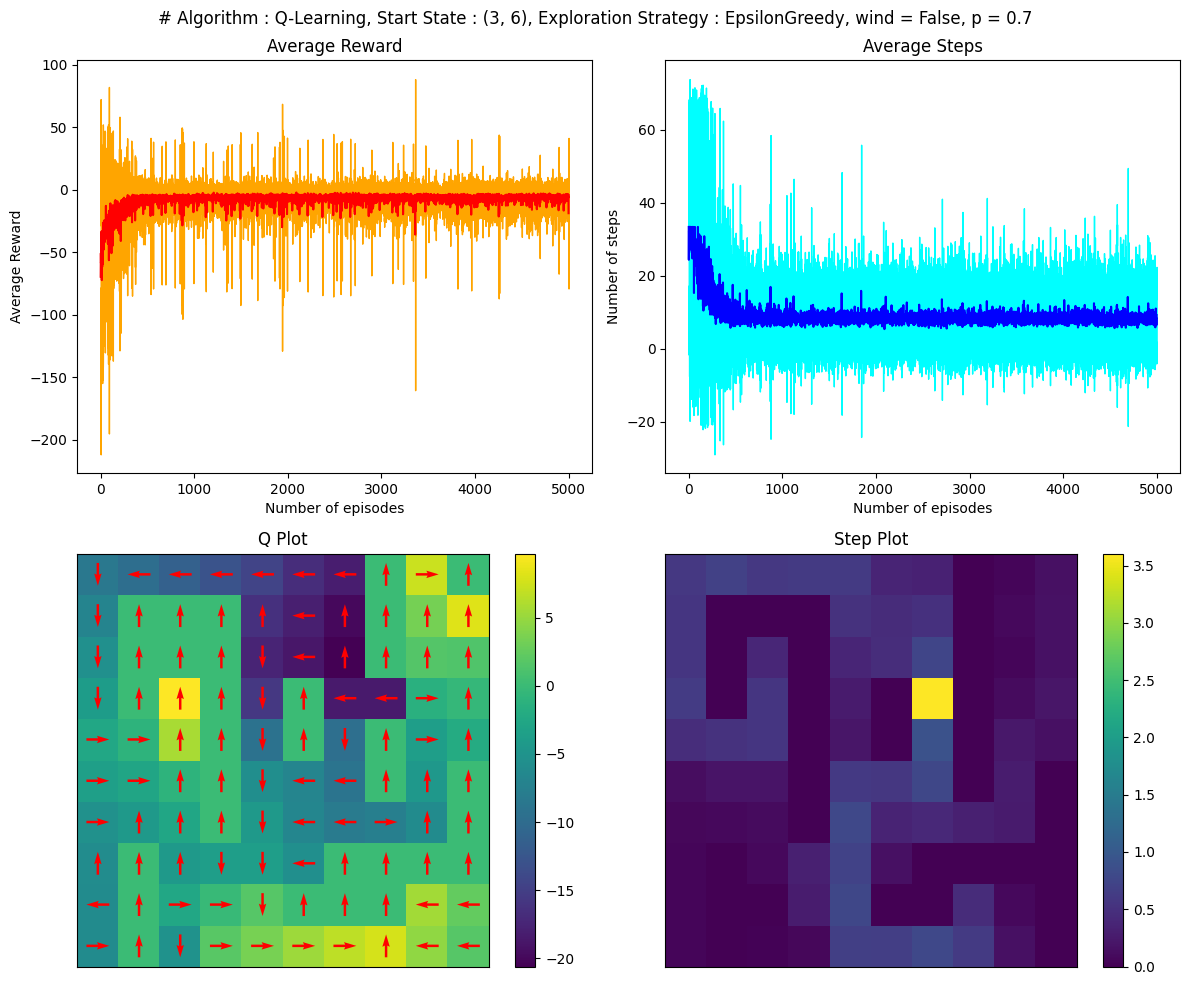

# Algorithm : Q-Learning, Start State : (3, 6), Exploration Strategy : EpsilonGreedy, wind = True, p = 1.0

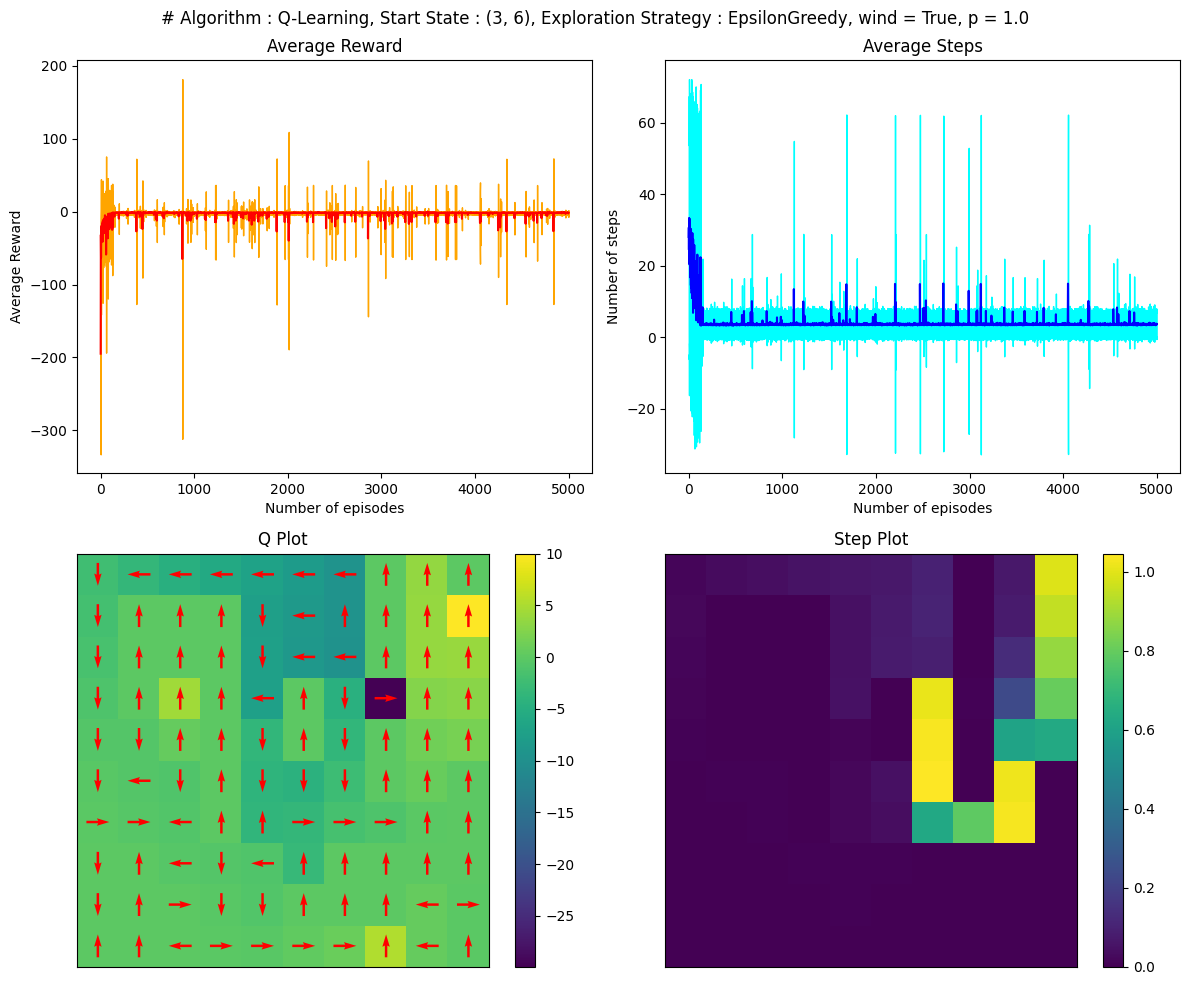

In [20]:
learning_algo = "Q-Learning"
strategy = "EpsilonGreedy"
start_states = np.array([[[0, 4]],[[3,6]]])
winds = [False,False,True]
ps = [1.0,0.7,1.0]
gamma = 1
param = 0.01
lr = 0.1

for start_state in start_states:
    for p,wind in zip(ps,winds):
        env = create_environment(start_state, wind, p)
        function = epsilon_greedy
        learning_algorithm = QLearning(
            env, function, param, lr, gamma)
        average_reward, average_steps, Q_average, state_visit_count_average = learning_algorithm.average_performance(
            number_of_epochs, number_of_episodes)
        title = "# Algorithm : " + learning_algo + ", " + "Start State : " + \
            str(tuple(start_state[0])) + ", " + "Exploration Strategy : " + \
            strategy + ", wind = " + str(wind) + ", p = " + str(p)
        mark(title)

        plot_combined(average_reward, average_steps, Q_average,
                    state_visit_count_average, episodes, title)

# average_reward_plot(average_reward, episodes, title)
# average_steps_plot(average_steps, episodes, title)
# plot_step(state_visit_count_average, title)
# plot_Q(Q_average, title)

# Trying out Various other hyper parameters

In [21]:
hyper_parameter_tuples = []

action_selection_functions = [softmax, epsilon_greedy]
action_selection_param_egreedys = [0.1, 0.01, 0.001]
action_selection_param_softmaxs = [2, 1, 0.1, 0.01]
gammas = [1, 0.9, 0.8, 0.7]
lrs = [1, 0.1, 0.01, 0.001]

for gamma in gammas:
    for lr in lrs:
        for action_selection_function in action_selection_functions:
            if action_selection_function == softmax:
                for action_selection_param in action_selection_param_softmaxs:
                    hyper_parameter_tuples.append(
                        (gamma, lr, action_selection_function, action_selection_param))
            elif action_selection_function == epsilon_greedy:
                for action_selection_param in action_selection_param_egreedys:
                    hyper_parameter_tuples.append(
                        (gamma, lr, action_selection_function, action_selection_param))

experiment_tuple = []
start_states = np.array([[[0, 4]], [[3, 6]]])
winds = [False, False, True]
ps = [1.0, 0.7, 1.0]

for start_state in start_states:
    for wind, p in zip(winds, ps):
        experiment_tuple.append((start_state, wind, p))

In [22]:
for experiment in experiment_tuple:
    max_avg_reward = -np.inf
    start_state, wind, p = experiment
    env = create_environment(start_state, wind, p)
    best_setting = None

    for hyper_parameter in tqdm.tqdm(hyper_parameter_tuples):
        print('Training for',hyper_parameter)
        gamma, lr, action_selection_function, action_selection_param = hyper_parameter
        learning_algorithm = QLearning(
            env, action_selection_function, action_selection_param, lr, gamma)
        average_reward, average_steps, Q_average, state_visit_count_average = learning_algorithm.average_performance(
            number_of_epochs, number_of_episodes)
        if np.mean(average_reward) > max_avg_reward:
            max_avg_reward = np.mean(max_avg_reward)
            best_setting = (gamma, lr, action_selection_function,
                            action_selection_param)
            results = (average_reward, average_steps,
                       Q_average, state_visit_count_average)

    gamma, lr, action_selection_function, action_selection_param = best_setting
    title = "# Algorithm : " + learning_algo + ", " + "Start State : " + \
        str(tuple(start_state[0])) + ", " + "Exploration Strategy : " + \
        strategy + ", wind = " + str(wind) + ", p = " + str(p)
    mark(title)
    average_reward, average_steps, Q_average, state_visit_count_average = results
    plot_combined(average_reward, average_steps, Q_average,
                    state_visit_count_average, episodes, title)
    title = f"The best settings with hyper params: lr:{lr} gamma:{gamma} policy:{action_selection_function} policy_params:{action_selection_param}"
    mark(title)

  0%|          | 0/112 [00:00<?, ?it/s]

Training for (1, 1, <function softmax at 0x7f74f8de9940>, 2)


  1%|          | 1/112 [00:21<40:05, 21.67s/it]

Training for (1, 1, <function softmax at 0x7f74f8de9940>, 1)


  2%|▏         | 2/112 [00:40<36:07, 19.71s/it]

Training for (1, 1, <function softmax at 0x7f74f8de9940>, 0.1)


  3%|▎         | 3/112 [01:05<40:47, 22.45s/it]

Training for (1, 1, <function softmax at 0x7f74f8de9940>, 0.01)


  4%|▎         | 4/112 [01:31<42:49, 23.79s/it]

Training for (1, 1, <function epsilon_greedy at 0x7f74f8de9260>, 0.1)


  4%|▍         | 5/112 [02:02<47:14, 26.49s/it]

Training for (1, 1, <function epsilon_greedy at 0x7f74f8de9260>, 0.01)


  5%|▌         | 6/112 [02:13<37:31, 21.24s/it]

Training for (1, 1, <function epsilon_greedy at 0x7f74f8de9260>, 0.001)


  6%|▋         | 7/112 [02:24<31:19, 17.90s/it]

Training for (1, 0.1, <function softmax at 0x7f74f8de9940>, 2)


  7%|▋         | 8/112 [02:59<40:07, 23.15s/it]

Training for (1, 0.1, <function softmax at 0x7f74f8de9940>, 1)


  8%|▊         | 9/112 [03:19<38:12, 22.26s/it]

Training for (1, 0.1, <function softmax at 0x7f74f8de9940>, 0.1)


  9%|▉         | 10/112 [03:37<35:34, 20.92s/it]

Training for (1, 0.1, <function softmax at 0x7f74f8de9940>, 0.01)


 10%|▉         | 11/112 [03:55<33:38, 19.99s/it]

Training for (1, 0.1, <function epsilon_greedy at 0x7f74f8de9260>, 0.1)


 11%|█         | 12/112 [04:04<27:37, 16.58s/it]

Training for (1, 0.1, <function epsilon_greedy at 0x7f74f8de9260>, 0.01)


 12%|█▏        | 13/112 [04:12<22:59, 13.94s/it]

Training for (1, 0.1, <function epsilon_greedy at 0x7f74f8de9260>, 0.001)


 12%|█▎        | 14/112 [04:19<19:39, 12.04s/it]

Training for (1, 0.01, <function softmax at 0x7f74f8de9940>, 2)


 13%|█▎        | 15/112 [05:29<47:35, 29.44s/it]

Training for (1, 0.01, <function softmax at 0x7f74f8de9940>, 1)


 13%|█▎        | 15/112 [05:32<35:50, 22.17s/it]


KeyboardInterrupt: 